In [1]:
pip install torch transformers datasets numpy matplotlib tqdm psutil bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install -U bitsandbytes

## Install Desired Libraries

In [3]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2LMHeadModel
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import psutil
import os
import time
import gc
import bitsandbytes as bnb
from torch.utils.data import Dataset, DataLoader
import copy


## Create the text dataset

In [4]:
class TextDataset(Dataset):
    """Custom Dataset for GPT2"""
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

## Calculate Memory Requirement for the Model

In [13]:
def calculate_model_memory(model, quantized_bits=32):
    """
    Calculates the memory usage of the model. If quantized, it assumes
    that the model weights are quantized to the specified bit-width.

    Parameters:
    - model: The PyTorch model
    - quantized_bits: The bit-width of the quantized model weights. Can be 32, 8, or 4.

    Returns:
    - Memory usage in MB
    """
    total_params = sum(p.numel() for p in model.parameters())

    # Set the number of bytes per parameter based on the quantization bit-width
    if quantized_bits == 32:
        param_size_in_bytes = 4  # 4 bytes per parameter for 32-bit (default float)
    elif quantized_bits == 8:
        param_size_in_bytes = 1  # 1 byte per parameter for 8-bit quantization
    elif quantized_bits == 4:
        param_size_in_bytes = 0.5  # 0.5 byte per parameter for 4-bit quantization
    else:
        raise ValueError("Supported quantized bit-widths are 32, 8, and 4.")

    # Calculate total memory usage (in bytes), then convert to MB
    total_memory = total_params * param_size_in_bytes / (1024 * 1024)  # Convert bytes to MB
    return total_memory

## Create the Quantisation Class

In [6]:
class ModelQuantizer:
    """Handles different quantization methods using bitsandbytes"""
    def __init__(self, model_name='gpt2', device='cuda'):
        self.model_name = model_name
        self.device = device
        self.original_model = None
        self.model_8bit = None
        self.model_4bit = None
        self.model_nf4 = None

    def load_original_model(self):
        """Load the original FP16/32 model"""
        self.original_model = AutoModelForCausalLM.from_pretrained(
            self.model_name
        ).to(self.device)
        return self.original_model

    def load_8bit_model(self):
        """Load 8-bit quantized model"""
        self.model_8bit = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            load_in_8bit=True,
            device_map='auto'
        )
        torch.save(self.model_8bit.state_dict(), 'gpt2_8bit_quantized.pth')
        return self.model_8bit

    def load_4bit_model(self):
        """Load 4-bit quantized model"""
        self.model_4bit = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            device_map='auto'
        )
        torch.save(self.model_4bit.state_dict(), 'gpt2_4bit_quantized.pth')
        return self.model_4bit

    def load_nf4_model(self):
        """Load NF4 quantized model"""
        self.model_nf4 = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_quant_type="nf4",
            device_map='auto'
        )
        torch.save(self.model_nf4.state_dict(), 'gpt2_nf4_quantized.pth')
        return self.model_nf4


## Prepare the Dataset

In [11]:
def prepare_dataset(tokenizer, max_length=512):
    """Prepare Wikipedia dataset for evaluation"""
    dataset = load_dataset("wikipedia", "20220301.en", split="train[:3000]")

    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

    encodings = tokenize_function(dataset)
    dataset = TextDataset(encodings)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

    return dataloader

## Functions to Calculate Perplexity and Latency

In [7]:
def calculate_perplexity(model, eval_dataloader, device):
    """Calculate model perplexity"""
    model.eval()
    total_loss = 0
    total_length = 0

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Calculating perplexity"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = input_ids.clone()

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss_fct = torch.nn.CrossEntropyLoss(reduction='sum')
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)),
                          shift_labels.view(-1))

            total_loss += loss.item()
            total_length += attention_mask.sum().item()

    return torch.exp(torch.tensor(total_loss / total_length))

In [8]:
def measure_inference_latency(model, input_ids, attention_mask, num_runs=200):
    """Measure inference latency"""
    latencies = []
    model.eval()

    with torch.no_grad():
        # Warmup
        for _ in range(10):
            _ = model(input_ids, attention_mask=attention_mask)

        # Measure latency
        for _ in tqdm(range(num_runs), desc="Measuring latency"):
            start_time = time.time()
            _ = model(input_ids, attention_mask=attention_mask)
            latencies.append((time.time() - start_time) * 1000)  # Convert to ms

    return np.mean(latencies), np.std(latencies)

In [23]:
def plot_comparison(metrics, title, ylabel):
    """Plot comparison metrics with enhanced y-axis scaling"""
    plt.figure(figsize=(6, 6))
    x = range(len(metrics['labels']))

    # Create bar plot
    bars = plt.bar(x, metrics['values'], color='skyblue')
    plt.xticks(x, metrics['labels'], rotation=45)
    plt.title(title)
    plt.ylabel(ylabel)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    # Adjust y-axis scale for better visualization
    y_min = min(metrics['values']) * 0.95
    y_max = max(metrics['values']) * 1.05
    plt.ylim(y_min, y_max)

    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize components
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
quantizer = ModelQuantizer('gpt2', device)

# Prepare dataset
eval_dataloader = prepare_dataset(tokenizer)


Using device: cuda


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

wikipedia.py:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


train-00000-of-00041.parquet:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

train-00001-of-00041.parquet:   0%|          | 0.00/705M [00:00<?, ?B/s]

train-00002-of-00041.parquet:   0%|          | 0.00/558M [00:00<?, ?B/s]

train-00003-of-00041.parquet:   0%|          | 0.00/491M [00:00<?, ?B/s]

train-00004-of-00041.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

train-00005-of-00041.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

train-00006-of-00041.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

train-00007-of-00041.parquet:   0%|          | 0.00/326M [00:00<?, ?B/s]

train-00008-of-00041.parquet:   0%|          | 0.00/329M [00:00<?, ?B/s]

train-00009-of-00041.parquet:   0%|          | 0.00/312M [00:00<?, ?B/s]

train-00010-of-00041.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

train-00011-of-00041.parquet:   0%|          | 0.00/247M [00:00<?, ?B/s]

train-00012-of-00041.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00013-of-00041.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

train-00014-of-00041.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

train-00015-of-00041.parquet:   0%|          | 0.00/236M [00:00<?, ?B/s]

train-00016-of-00041.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

train-00017-of-00041.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

train-00018-of-00041.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00019-of-00041.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

train-00020-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00021-of-00041.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00022-of-00041.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00023-of-00041.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00024-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00025-of-00041.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

train-00026-of-00041.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

train-00027-of-00041.parquet:   0%|          | 0.00/206M [00:00<?, ?B/s]

train-00028-of-00041.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

train-00029-of-00041.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00030-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00031-of-00041.parquet:   0%|          | 0.00/216M [00:00<?, ?B/s]

train-00032-of-00041.parquet:   0%|          | 0.00/200M [00:00<?, ?B/s]

train-00033-of-00041.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

train-00034-of-00041.parquet:   0%|          | 0.00/201M [00:00<?, ?B/s]

train-00035-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00036-of-00041.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

train-00037-of-00041.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

train-00038-of-00041.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

train-00039-of-00041.parquet:   0%|          | 0.00/192M [00:00<?, ?B/s]

train-00040-of-00041.parquet:   0%|          | 0.00/185M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6458670 [00:00<?, ? examples/s]

In [14]:
# Dictionary to store results
results = {
    'memory': {'labels': [], 'values': []},
    'perplexity': {'labels': [], 'values': []},
    'latency': {'labels': [], 'values': []},
}

In [15]:
# Test original model
print("\nTesting original model...")
model = quantizer.load_original_model()
sample_batch = next(iter(eval_dataloader))

results['memory']['labels'].append('Original')
results['memory']['values'].append(calculate_model_memory(model))


perplexity = calculate_perplexity(model, eval_dataloader, device)
results['perplexity']['labels'].append('Original')
results['perplexity']['values'].append(perplexity.item())

latency, _ = measure_inference_latency(
    model,
    sample_batch['input_ids'].to(device),
    sample_batch['attention_mask'].to(device)
)
results['latency']['labels'].append('Original')
results['latency']['values'].append(latency)


Testing original model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

<ipython-input-4-578830623201>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Measuring latency: 100%|██████████| 200/200 [01:02<00:00,  3.18it/s]


In [16]:
del model
gc.collect()
torch.cuda.empty_cache()

In [21]:
# Test 8-bit quantization
print("\nTesting 8-bit quantization...")
model = quantizer.load_8bit_model()

results['memory']['labels'].append('8-bit')
results['memory']['values'].append(calculate_model_memory(model,8))

perplexity = calculate_perplexity(model, eval_dataloader, device)
results['perplexity']['labels'].append('8-bit')
results['perplexity']['values'].append(perplexity.item())

latency, _ = measure_inference_latency(
    model,
    sample_batch['input_ids'].to(device),
    sample_batch['attention_mask'].to(device)
)

results['latency']['labels'].append('8-bit')
results['latency']['values'].append(latency)

del model
gc.collect()
torch.cuda.empty_cache()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



Testing 8-bit quantization...


Calculating perplexity:   0%|          | 0/375 [00:00<?, ?it/s]<ipython-input-4-578830623201>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Measuring latency: 100%|██████████| 200/200 [00:27<00:00,  7.21it/s]


In [17]:
# Test 4-bit linear quantization
print("\nTesting 4-bit linear quantization...")
model = quantizer.load_4bit_model()


# Track memory usage
results['memory']['labels'].append('4-bit')
results['memory']['values'].append(calculate_model_memory(model,4))

perplexity = calculate_perplexity(model, eval_dataloader, device)
results['perplexity']['labels'].append('4-bit')
results['perplexity']['values'].append(perplexity.item())

latency, _ = measure_inference_latency(
    model,
    sample_batch['input_ids'].to(device),
    sample_batch['attention_mask'].to(device)
)
results['latency']['labels'].append('4-bit')
results['latency']['values'].append(latency)

del model
gc.collect()
torch.cuda.empty_cache()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



Testing 4-bit linear quantization...


Calculating perplexity:   0%|          | 0/375 [00:00<?, ?it/s]<ipython-input-4-578830623201>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Measuring latency: 100%|██████████| 200/200 [00:18<00:00, 11.00it/s]


In [18]:
# Test NF4 quantization
print("\nTesting NF4 quantization...")
model = quantizer.load_nf4_model()

results['memory']['labels'].append('NF4')
results['memory']['values'].append(calculate_model_memory(model,4))

perplexity = calculate_perplexity(model, eval_dataloader, device)
results['perplexity']['labels'].append('NF4')
results['perplexity']['values'].append(perplexity.item())

latency, _ = measure_inference_latency(
    model,
    sample_batch['input_ids'].to(device),
    sample_batch['attention_mask'].to(device)
)
results['latency']['labels'].append('NF4')
results['latency']['values'].append(latency)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



Testing NF4 quantization...


Calculating perplexity:   0%|          | 0/375 [00:00<?, ?it/s]<ipython-input-4-578830623201>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Measuring latency: 100%|██████████| 200/200 [00:18<00:00, 11.02it/s]


In [22]:
# Print summary
print("\nQuantization Results Summary:")
print("\nMemory Usage (MB):")
for label, value in zip(results['memory']['labels'], results['memory']['values']):
    print(f"  {label}: {value:.2f}")

print("\nPerplexity:")
for label, value in zip(results['perplexity']['labels'], results['perplexity']['values']):
    print(f"  {label}: {value:.2f}")

print("\nInference Latency (ms):")
for label, value in zip(results['latency']['labels'], results['latency']['values']):
    print(f"  {label}: {value:.2f}")


Quantization Results Summary:

Memory Usage (MB):
  Original: 474.70
  4-bit: 39.09
  NF4: 39.09
  8-bit: 118.68

Perplexity:
  Original: 41.00
  4-bit: 44.55
  NF4: 44.45
  8-bit: 41.48

Inference Latency (ms):
  Original: 311.93
  4-bit: 89.58
  NF4: 89.68
  8-bit: 136.59


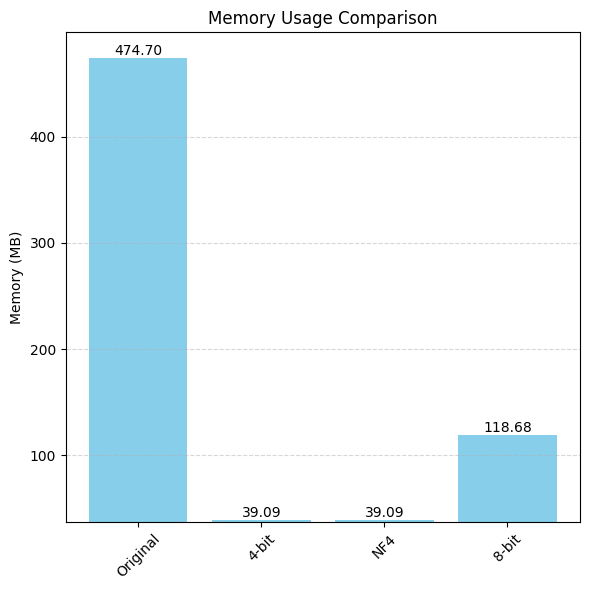

In [25]:
# Plot results directly without saving to a file
plot_comparison(results['memory'],
               'Memory Usage Comparison',
               'Memory (MB)')


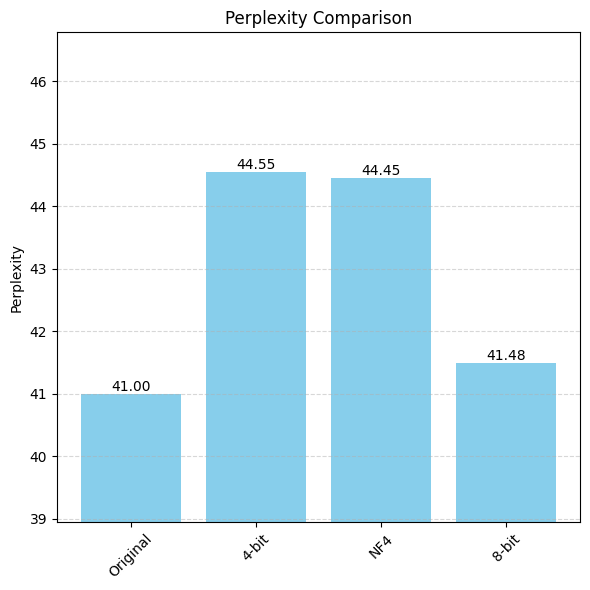

In [26]:

plot_comparison(results['perplexity'],
               'Perplexity Comparison',
               'Perplexity')


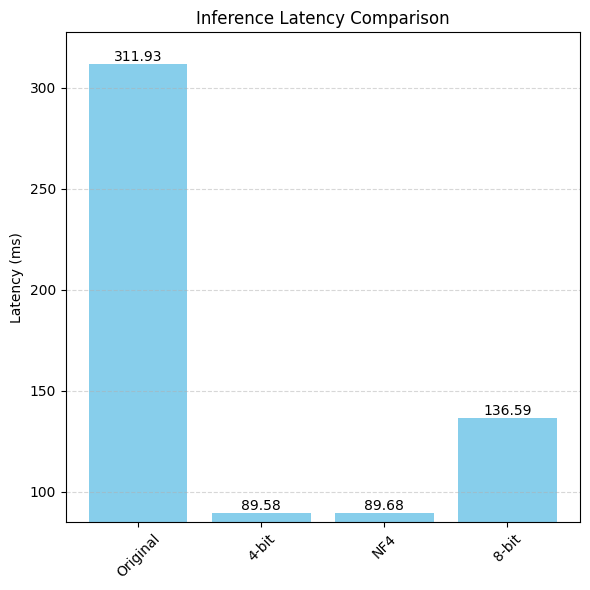

In [27]:

plot_comparison(results['latency'],
               'Inference Latency Comparison',
               'Latency (ms)')